# CSE527 Homework 1 (part 3)
**Due date: 11:59 pm on Sep 22, 2024 (EST)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.

## Setup Environment
---







## Problem 3: Ray casting using Blinn-Phong model (40pts)


#### Description
----
In this problem, you will be estimating the camera captured image given the camera parameters, scene geometry, lighting and materials using
[Blinn-Phong illumination model](https://dl.acm.org/doi/abs/10.1145/563858.563893), an improved version of [Phong illumination model](https://dl.acm.org/doi/abs/10.1145/360825.360839).

The six parts below will guide you to render an image using ray casting and Phong model step by step.

In [1]:
# import packages here
import numpy as np
import cv2 as cv
from math import sqrt, fmod, pi
import matplotlib.pyplot as plt

print(cv.__version__) # verify OpenCV version

# figure and show
def imshow(im, title=None):
    im = im.squeeze()

    # remove white paddings
    fig = plt.figure()
    # fig.canvas.window().statusBar().setVisible(False)

    # display image
    ax = plt.imshow(im, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    if title is not None:
        plt.title(title)
        plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0, hspace=0, wspace=0)
    plt.show()
    return fig

# A 3x1 vector class extended from np.ndarray
class Vec3(np.ndarray):
    def __new__(cls, x, y=None, z=None):
        if y is None and z is None:
            data = np.array([x, x, x])
        else:
            data = np.array([x, y, z])
        return data.view(cls)

    # vector normal
    def norm(self):
        return np.linalg.norm(self)

    # normalized vector
    def normalize(self):
        return self / self.norm()

    # vector cross product
    def cross(self, b):
        return np.cross(self, b)

4.10.0


### Part 1: Compute camera intrinsic matrix and camera ray
(10 points) Compute the 3x3 camera intrinsic matrix from the given camera image size, sensor size and focal length. Then, for each camera image pixel, we shoot a camera ray from the camera optical center (ray origin) and pass it through the pixel. Implement your alogrithm in `cam_ray_dir`.

**Hint**: refer to slides, you will compute each camera ray direction using inverse of camera matrix.


In [2]:
# create a perspective camera model. DO NOT MODIFY them
cam_pos = Vec3(0, 0, 0)
cam_h, cam_w = (500, 500)  # camera image size (pixel)
sensor_h, sensor_w = (36, 36)  # camera sensor size (mm)
focal_length = 50  # camera lens focal length (mm)

fx, fy = (focal_length / sensor_w * cam_w, focal_length / sensor_h * cam_h)
cx, cy = (cam_w / 2, cam_h / 2)
cam_k = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])  # camera intrinsics

inv_cam_k = np.linalg.inv(cam_k)  # precompute inverse of camera intrinsics

# compute the direction of the camera ray that passes through camera optical center (ray origin) and pixel (x, y)
def cam_ray_dir(inv_cam_k, cam_pos, focal_length, x, y):
  ray_dir = None

  ##########--WRITE YOUR CODE HERE--##########

  # direction = normalize(f * inv(K) * [x, y, 1].T - Oc)
  ray_dir = (focal_length * (inv_cam_k @ Vec3(x, y, 1)) - cam_pos).normalize()

  ##########-------END OF CODE-------##########
  return ray_dir

print('camera intrinsics = \n', cam_k)

camera intrinsics = 
 [[694.44444444   0.         250.        ]
 [  0.         694.44444444 250.        ]
 [  0.           0.           1.        ]]


### Part 2: Compute ray-object intersection
(10 points) For each camera ray, you will compute the intersection point of the camera ray with each object in the scene and store the intersection information in an `Intersection` object. Implement sphere-ray intersections, plane-ray intersections and ray-scene intersections below.

In [3]:
# A class used to store ray-object intersection information
class Intersection(object):
    def __init__(self, point, distance, normal, obj):
        self.p = point  # intersection point/position
        self.d = distance  # distance between this intersection and ray origin
        self.n = normal  # surface normal at this intersection
        self.obj = obj  # which object this intersection belongs to

# Light ray class
class Ray(object):
    def __init__(self, origin, direction):
        self.o = origin
        self.d = direction

    # ray-object intersection
    def intersect(self, obj):
        return obj.intersect(self)

    # ray intersect scene i.e., check intersections with all objects.
    # return the closest if at lease one intersection, otherwise return none
    def intersect_scene(self, scene, ignored_obj=None):
        inter = None # returned inter is an instance of Intersection

        ##########--WRITE YOUR CODE HERE--##########

        for obj in scene:
            new_inter = obj.intersect(self)

            if new_inter is None:
                continue
            elif inter is None or new_inter.d < inter.d:
                inter = new_inter

        ##########-------END OF CODE-------##########

        return inter

# Sphere class
class Sphere(object):
    def __init__(self, center, radius, material=None):
        self.c = center
        self.r = radius
        self.rr = radius ** 2  # precompute r^2 for faster ray casting
        self.mat = material  # Phong material

    def intersect(self, l):  # intersect with ray l
        inter = None # returned inter is an instance of Intersection
        # solve quadratic equation of ray-sphere intersection

        ##########--WRITE YOUR CODE HERE--##########

        # Intersection point for sphere:
        # solution of at**2 + bt + c = 0
        # for
        # a = dir.dir
        # b = 2(origin-center).d
        # c = (origin-center).(origin-center) - radius**2
        a = l.d.dot(l.d)
        b = 2 * (l.o - self.c).dot(l.d)
        c = (l.o - self.c).dot((l.o - self.c)) - self.rr

        # No intersection of determinant < 0
        det = b ** 2 - 4 * a * c
        if det < 0:
            return None

        # Select intersection at lesser distance
        t1 = (-b + det ** 0.5) / (2 * a)
        t2 = (-b - det ** 0.5) / (2 * a)
        t = t1 if t1 < t2 else t2

        # Create intersection object
        point = l.o + t * l.d
        distance = t * l.d.norm()
        normal = point - self.c
        inter = Intersection(point, distance, normal, self)

        ##########-------END OF CODE-------##########

        return inter


# Plane class
class Plane(object):
    def __init__(self, point, normal, material=None):
        self.p = point  # a point on the plane
        self.n = normal  # must be a normalized Vec3
        self.mat = material  # Phong material

    def intersect(self, l):  # intersect with ray l
        inter = None # returned inter is an instance of Intersection

        ##########--WRITE YOUR CODE HERE--##########

        # Intersection for plane:
        # t = (p'-o).N / dir.N
        t_num = (self.p - l.o).dot(self.n)
        t_den = l.d.dot(self.n)

        # Safegaurd for zero denominator
        if t_den == 0:
          return None
        # Compute t
        t = (t_num / t_den)
        # Safegaurd for negative distances
        if t < 0:
            return None

        # Create intersection object
        point = l.o + t * l.d
        distance = t * l.d.norm()
        normal = self.n
        inter = Intersection(point, distance, normal, self)

        ##########-------END OF CODE-------##########

        return inter

### Part 3: Render a vanilla ray casting image
(10 points) This part aims to help you sanity check the ray-object intersection algorithms above by rendering an image with `vanilla_ray_cast `. You will set a camera image pixel to (0.5,0.5,0.5) if its corresponding camera ray hits an object in the scene, otherwise set it to (0,0,0). You will compute the ray direction using `cam_ray_dir` and create a variable `ray` using `Ray(origin, dir)`, then `vanilla_ray_cast` will compute the current pixel color.

Ray casting...
0.00%
10.00%
20.00%
30.00%
40.00%
50.00%
60.00%
70.00%
80.00%
90.00%


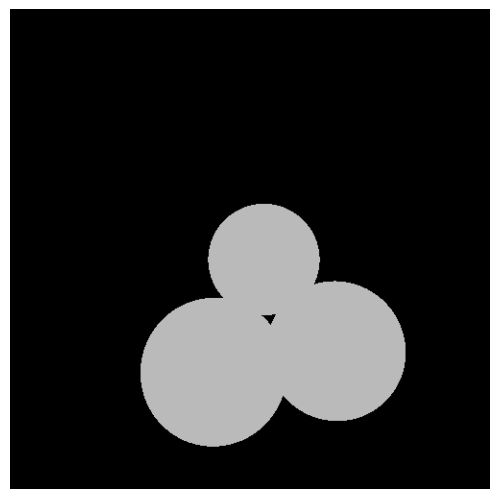

True

In [4]:
#  Only check if ray intersects the objects or not, does not computer color
def vanilla_ray_cast(ray, objects):
    inter = ray.intersect_scene(objects)
    if inter is None:
        color = Vec3(0, 0, 0)
    else:
        color = Vec3(1, 1, 1)*0.5
    return color

# initialize scene with three spheres
scene = []  # scene stores a list of objects
scene.append(Sphere(Vec3(12, 9, 600), 50))
scene.append(Sphere(Vec3(-30, 100, 550), 60))
scene.append(Sphere(Vec3(80, 95, 630), 65))

# camera captured image
img = np.zeros((cam_h, cam_w, 3))

# render using ray casting
print('Ray casting...')
for x in range(cam_w):  # for each col
    if fmod(x, cam_w // 10) == 0:  # print ray casting progress
        print('{:.2f}%'.format(x / cam_w * 100))
    for y in range(cam_h):  # for each row

        ##########--WRITE YOUR CODE HERE--##########

        ray_direction = cam_ray_dir(inv_cam_k, cam_pos, focal_length, x, y)
        ray = Ray(cam_pos, ray_direction)

        ##########-------END OF CODE-------##########

        color = vanilla_ray_cast(ray, scene)
        img[y, x] = color

# apply gamma correction (1/2.2) for display
img = np.power(img, 1 / 2.2)
imshow(img)
cv.imwrite('results/vanilla_ray_cast.png', img[..., ::-1] * 255)



### Part 4: Render a Lambertian ray casting image
(10 points) If Part 3 is correctly implemented, you can estimate a simple lambertian shadings of the scene (add light, material but ignore shadow, ambient and specular).
Implement your algorithm in `diffuseColor`. Since we are dealing with colors, Phong materials are created and each object is assigned with a material.

Ray casting...
0.00%
10.00%
20.00%
30.00%
40.00%
50.00%
60.00%
70.00%
80.00%
90.00%


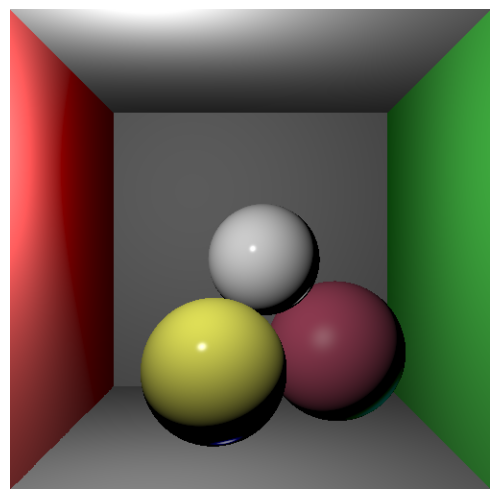

True

In [5]:
# Light source (point light)
class Light(object):
    def __init__(self, position, power, ambient, diffuse, specular):
        self.p = position  # position, Vec3
        self.power = power  # light intensity/brightness
        self.ambient = ambient
        self.diffuse = diffuse
        self.specular = specular

# Phong diffuse (lambertian) color
def diffuseColor(inter, light):
    color = 0

    ##########--WRITE YOUR CODE HERE--##########

    # Compute vectors
    light_vector = (light.p - inter.p).normalize()
    normal_vector = inter.n.normalize()
    reflected_light = 2 * normal_vector * light_vector.dot(normal_vector) - light_vector
    viewer_vector = Vec3(0, 0, -1).normalize()

    # Ambient: ka * Ia * Il
    ambient = (
        inter.obj.mat["ka"]
        * light.ambient
        * light.power
    )

    # Diffuse: kd * (L.N) * Id * Il
    diffuse = (
        inter.obj.mat["kd"]
        * light_vector.dot(normal_vector)
        * light.diffuse
        * light.power
    )

    # Specular: ks * (V.R) ** n * Id * Il
    specular = (
        inter.obj.mat["ks"]
        * viewer_vector.dot(reflected_light) ** inter.obj.mat["shine"]
        * light.specular
        * light.power
    )

    color = ambient + diffuse + specular

    ##########-------END OF CODE-------##########

    return color

#  Only compute lambertian (diffuse) color, no ambient or shadow
def lambertian_ray_cast(ray, objects, light):
    inter = ray.intersect_scene(objects)
    if inter is None:
        color = Vec3(0, 0, 0)
    else:
        d = (light.p - inter.p).norm()
        color = np.clip(diffuseColor(inter, light) / (4 * pi * d * d), 0, 1)
    return color

# Render
# Phong illumination materials
plaster_white = {'ka': Vec3(0.03), 'kd': Vec3(0.5), 'ks': Vec3(0.1), 'shine': 5}
plaster_red = {'ka': Vec3(0.9, 0.1, 0.1) * 0.01, 'kd': Vec3(0.9, 0.1, 0.1), 'ks': Vec3(0.1), 'shine': 5}
plaster_green = {'ka': Vec3(0.1, 0.9, 0.1) * 0.01, 'kd': Vec3(0.1, 0.9, 0.1), 'ks': Vec3(0.1), 'shine': 5}
marble_white = {'ka': Vec3(0.01), 'kd': Vec3(0.8), 'ks': Vec3(1.0), 'shine': 200.0}
marble_yellow = {'ka': Vec3(0.8, 0.8, 0.1) * 0.1, 'kd': Vec3(0.8, 0.8, 0.1), 'ks': Vec3(1.0), 'shine': 200.0}
plastic_red = {'ka': Vec3(0.7, 0.1, 0.2) * 0.01, 'kd': Vec3(0.7, 0.1, 0.2), 'ks': Vec3(0.2), 'shine': 20}

# initialize scene with spheres and a box
scene = []  # scene stores a list of objects
# a box
scene.append(Plane(Vec3(0, -160, 0), Vec3(0, 1, 0), plaster_white))  # ceiling
scene.append(Plane(Vec3(0, 160, 0), Vec3(0, -1, 0), plaster_white))  # floor
scene.append(Plane(Vec3(-160, 0, 0), Vec3(1, 0, 0), plaster_red))  # left
scene.append(Plane(Vec3(160, 0, 0), Vec3(-1, 0, 0), plaster_green))  # right
scene.append(Plane(Vec3(0, 0, 780), Vec3(0, 0, -1), plaster_white))  # back
# spheres
scene.append(Sphere(Vec3(12, 9, 600), 50, marble_white))
scene.append(Sphere(Vec3(-30, 100, 550), 60, marble_yellow))
scene.append(Sphere(Vec3(80, 95, 630), 65, plastic_red))

# initialize a point light
light = Light(Vec3(-68, -68, 400), 300000, Vec3(1.0), Vec3(1.0), Vec3(1.0))

# camera captured image
img = np.zeros((cam_h, cam_w, 3))

# render using ray casting
print('Ray casting...')
for x in range(cam_w):  # for each col
    if fmod(x, cam_w // 10) == 0:  # print ray casting progress
        print('{:.2f}%'.format(x / cam_w * 100))
    for y in range(cam_h):  # for each row

        ##########--WRITE YOUR CODE HERE--##########

        ray_direction = cam_ray_dir(inv_cam_k, cam_pos, focal_length, x, y)
        ray = Ray(cam_pos, ray_direction)

        ##########-------END OF CODE-------##########

        color = lambertian_ray_cast(ray, scene, light)
        img[y, x] = color

# apply gamma correction (1/2.2) for display
img = np.power(img, 1 / 2.2)
imshow(img)
cv.imwrite('results/lambertian_ray_cast.png', img[..., ::-1] * 255)



## What's more?
(0 points) For curious students

1.   Is the above image photorealistic enough? How can we improve it?
  *  Add more lights, materials and objects.
  *  Add textures.
  *  Render triangle mesh.
  *  Acceleration techniques, e.g., depth clipping, bounding box, BVH, k-d tree, multithreading, GPU.
  *  Antialiasing.
  *  Depth of field.
  *  Add transparency, inter-reflection, volume scattering, caustics, etc.


2.   How do human visual systems tell whether an image is real or fake? Apparently shadow is an important cue.
3.   Inverse problem: can we estimate lighting (direction and color), object surface normal, material and camera parameters from the image above?








## Submission Guidelines

This notebook should be submitted as a part of the root folder discussed in the submission guidelines @ CSE527_24F_HW1_P1.ipynb